# Multi-Site Wind Direction Hovmoller Plots
### Author: Danny Hogan
### Creation Date: 2/28/2024
Plots are created for the following sites under each project for the following dates:

**SAIL**
- ECOR tower located at Kettle Ponds: October 14, 2021 - June 16, 2023
- MET tower located in Gothic: September 29, 2021 - June 16, 2023

**SPLASH**
- RADSYS located at Brush Creek: October 14, 2021 - August 16, 2023
- RADSYS located at Kettle Ponds: October 14, 2021 - August 16, 2023
- MET tower located at Roaring Judy: September 28, 2021 - September 5, 2023

**SOS**
- 10 m wind direction on tower C: November 1, 2022 - June 19, 2023



In [ ]:
# Import packages
import act
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz
import seaborn as sns
import glob


### Open SPLASH data from Roaring Judy

In [2]:
# data downloaded from https://zenodo.org/records/10392121
all_files = glob.glob('../data/roaring_judy/NOAA_PSL_SurfaceMeteorology_RoaringJudy/*')
li = []
cols = [
"Datalogger ID",
"Year",
"Julian Day",
"HoursMinutes",
"Pressure (mb)",
"Temperature (C)",
"Relative Humidity (%)",
"Scalar Wind Speed (m/s)",
"Vector Wind Speed (m/s)",
"Wind Direction (degrees)",
"Wind Direction Standard Deviation (degrees)",
"Battery Voltage (volts)",
"Maximum Wind Speed (m/s)",
]
for filename in all_files:
    df = pd.read_csv(filename, header=None, names=cols)
    df['HoursMinutes'] = df['HoursMinutes'].astype(str)
    # add leading zero if length is 3
    df['HoursMinutes'] = df['HoursMinutes'].apply(lambda x: x.zfill(4))
    # split the last two digits
    df['Hours'] = df['HoursMinutes'].str[:-2]
    df['Minutes'] = df['HoursMinutes'].str[-2:]
    # convert year and julian day to datetime
    df['Year'] = df['Year'].astype(str)
    df['Julian Day'] = df['Julian Day'].astype(str)
    df['Julian Day'] = df['Year'] + '-' + df['Julian Day'] + ' ' + df['Hours'] + ':' + df['Minutes']
    df['Date'] = pd.to_datetime(df['Julian Day'], format='%Y-%j %H:%M')
    # drop Julian Day and HoursMinutes, Year, Hours, Minutes
    df = df.drop(columns=['Julian Day', 'HoursMinutes', 'Year', 'Hours', 'Minutes'])
    li.append(df)



In [3]:
all_df = pd.concat(li,axis=0)
all_df = all_df.set_index('Date', drop=True)
# add UTC timezone
all_df.index = all_df.index.tz_localize('UTC')
# convert to mountain time
all_df.index = all_df.index.tz_convert('US/Mountain')

all_df['u'] = -all_df['Scalar Wind Speed (m/s)'] * np.sin(np.deg2rad(all_df['Wind Direction (degrees)']))
all_df['v'] = -all_df['Scalar Wind Speed (m/s)'] * np.cos(np.deg2rad(all_df['Wind Direction (degrees)']))

In [4]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in all_df.index.month.unique():
    # calculate component mean wind direction
    component_mean_dir = all_df[all_df.index.month == month]
    u = component_mean_dir.u.groupby(component_mean_dir.index.hour).mean()
    v = component_mean_dir.v.groupby(component_mean_dir.index.hour).mean()
    dir = pd.Series(np.rad2deg(np.arctan2(-u,-v)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month
    
    # calculate median wind direction
    hourly_median_dir = all_df[all_df.index.month == month]['Wind Direction (degrees)']
    hourly_median_dir = hourly_median_dir.groupby(hourly_median_dir.index.hour).median()
    hourly_median_dir.name = month
    # add your choice of wind direction method to the list
    tmp.append(hourly_median_dir)

roaring_judy_hourly = pd.concat(tmp, axis=1).T
roaring_judy_hourly = roaring_judy_hourly.sort_index()

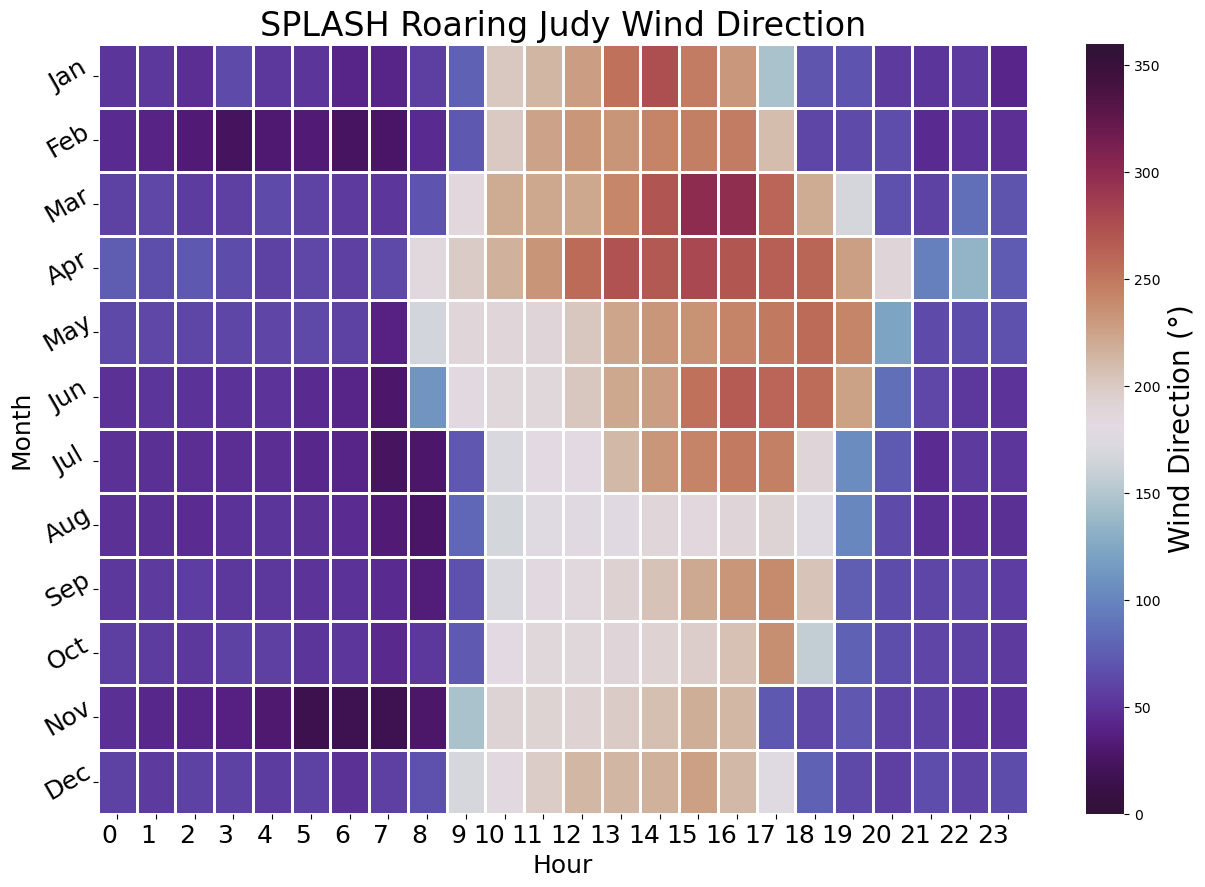

In [5]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(roaring_judy_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(roaring_judy_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SPLASH Roaring Judy Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

### RADSYS data from Kettle Ponds

In [6]:
def met_data_formatting(ckp_df):
    """Formatting for radsys data"""
    # Convert DateTime column to datetime
    ckp_df['time'] = pd.to_datetime(ckp_df['time'], format='%Y %m %d %H %M')
    # Add column numbers
    col_num = [1,2,3,4,5,6,7,8,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
    col_num = [num - 1 for num in col_num]
    col_names = ["yyyy","jday","month","day","hour","min","dt","SZA","dw_solar","uw_solar","Direct horizontal","Diffuse",
                "dw_ir","DwCaseTemp","DwDomeTemp","uw_ir","UwCaseTemp","UwDomeTemp","UVB","PAR","NetSolar","NetIR",
                "TotalNet","AirTemp","RH","WindSpd","WindDir","Baro","SPN1_total_Avg","SPN1_diffuse_Avg"]
    ckp_df = ckp_df.rename(columns = dict(zip(col_num, col_names))) 
    # Create QC column names
    qc_col_numbers = ckp_df.columns[5::2]
    new_qc_names = [f'{col_name}_qc' for col_name in ckp_df.columns[4::2]]
    ckp_df = ckp_df.rename(columns = dict(zip(qc_col_numbers,new_qc_names)))

    ckp_ds = ckp_df.set_index('time', drop=True).to_xarray()
    return ckp_ds


In [7]:
attributes_dict = {"SZA":
{"value":"solar zenith angle",
"units":"Degrees",
"type":"Float",
"QC":"Calc From Timestamp and Lat/Lon"},
"dw_solar":
{"value":"downwelling global solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 10"},
"uw_solar":
{"value":"upwelling global solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 12"},
"Direct horizontal":
{"value":"Direct horizontal solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 14, calculated as described below"},
"Diffuse":
{"value":"Downwelling diffuse solar",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 16, calculated as described below"},
"dw_ir":
{"value":"downwelling thermal infrared",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 18"},
"DwCaseTemp":
{"value":"downwelling IR case temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 20"},
"DwDomeTemp":
{"value":"downwelling IR dome temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 22"},
"uw_ir":
{"value":"upwelling thermal infrared",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 24"},
"UwCaseTemp":
{"value":"upwelling IR case temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 26"},
"UwDomeTemp":
{"value":"upwelling IR dome temp.",
"units":"Kelvin",
"type":"Float",
"QC":"QC = Col 28"},
"UV":
{"value":"global UVB",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 30, not usually measured with RADSYS"},
"PAR":
{"value":"photosynthetically active radiation",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 32, not usually measured with RADSYS"},
"NetSolar":
{"value":"net solar (dw_solar - uw_solar)",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 34"},
"NetIR":
{"value":"net infrared (dw_ir - uw_ir)",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 36"},
"TotalNet":
{"value":"net radiation (netsolar+netir)",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 38"},
"AirTemp":
{"value":"10-meter air temperature",
"units":"Celcius",
"type":"Float",
"QC":"QC = Col 40"},
"RH":
{"value":"relative humidity",
"units":"%",
"type":"Float",
"QC":"QC = Col 42"},
"WindSpd":
{"value":"wind speed",
"units":"m/s",
"type":"Float",
"QC":"QC = Col 44"},
"WindDir":
{"value":"wind direction",
"units":"Degrees",
"type":"Float",
"QC":"QC = Col 46"},
"Baro":
{"value":"station pressure",
"units":"mBar",
"type":"Float",
"QC":"QC = Col 48"},
"SPN1_total_Avg": 
{"value":"Total irradiance as measured by SPN1",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 50"},
"SPN1_diffuse_Avg":
{"value":"Diffuse irradiance as measured by SPN1",
"units":"W/m^2",
"type":"Float",
"QC":"QC = Col 52"}}

In [8]:
# downloaded from https://zenodo.org/records/10011476
all_files = glob.glob('../data/ckp/*.dat')
datasets = []
for fn in all_files:
    try:
        ckp_df = pd.read_csv(fn, 
                            skiprows=2, 
                            header=None, 
                            delim_whitespace=True, 
                            parse_dates={'time':[0,2,3,4,5]}, 
                            date_format='%Y %m %d %H %M',)
        datasets.append(met_data_formatting(ckp_df))
    except:
        print(fn)
        continue
    # read in data
radsys_ds = xr.concat(datasets, dim='time')
radsys_ds.attrs.update({'QC_flag':'0 for good data, 1 for bad data, 2 for questionable data',
                    'no_data': -9999.9,
                    'time':'UTC',
                    'reported_data':'Reported data are 1 minute averages of 1 second samples, reported times are the end of the 1-min. averaging period',
                    'datastreamname':'Radsys'})
# add a coordinate with LocalTime for Plotting
time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
radsys_ds.coords.update({'local_time':tz_corrected})


    # with open('./radsys_attributes.txt', 'r') as j:
    #     attribute_dict = json.loads(j.read())
attributes = attributes_dict
for variable in radsys_ds.variables:
    if variable in attributes.keys():
        radsys_ds[variable].attrs.update(attributes[variable])

../data/ckp/ckp22199.dat
../data/ckp/ckp22262.dat
../data/ckp/ckp22311.dat
../data/ckp/ckp22363.dat
../data/ckp/ckp23110.dat
../data/ckp/ckp23124.dat
../data/ckp/ckp23127.dat
../data/ckp/ckp23152.dat
../data/ckp/ckp23153.dat
../data/ckp/ckp23170.dat
../data/ckp/ckp23171.dat
../data/ckp/ckp23187.dat
../data/ckp/ckp23194.dat


In [9]:
ckp_radsys_df = radsys_ds.to_dataframe().set_index('local_time')
# fill -9999.9 with NaN
ckp_radsys_df = ckp_radsys_df.replace(-9999.9, np.nan)

In [10]:
ckp_radsys_df['u'] = -ckp_radsys_df['WindSpd'] * np.sin(np.deg2rad(ckp_radsys_df['WindDir']))
ckp_radsys_df['v'] = -ckp_radsys_df['WindSpd'] * np.cos(np.deg2rad(ckp_radsys_df['WindDir']))

In [11]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in ckp_radsys_df.index.month.unique():
    # component mean wind direction
    component_mean_dir = ckp_radsys_df[ckp_radsys_df.index.month == month]
    u = component_mean_dir.u.groupby(component_mean_dir.index.hour).mean()
    v = component_mean_dir.v.groupby(component_mean_dir.index.hour).mean()
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month

    # Median wind direction
    hourly_median_dir = ckp_radsys_df[ckp_radsys_df.index.month == month]['WindDir']
    hourly_median_dir = hourly_median_dir.groupby(hourly_median_dir.index.hour).median()
    hourly_median_dir.name=month
    tmp.append(hourly_median_dir)
kettle_ponds_hourly = pd.concat(tmp, axis=1).T
kettle_ponds_hourly = kettle_ponds_hourly.sort_index()

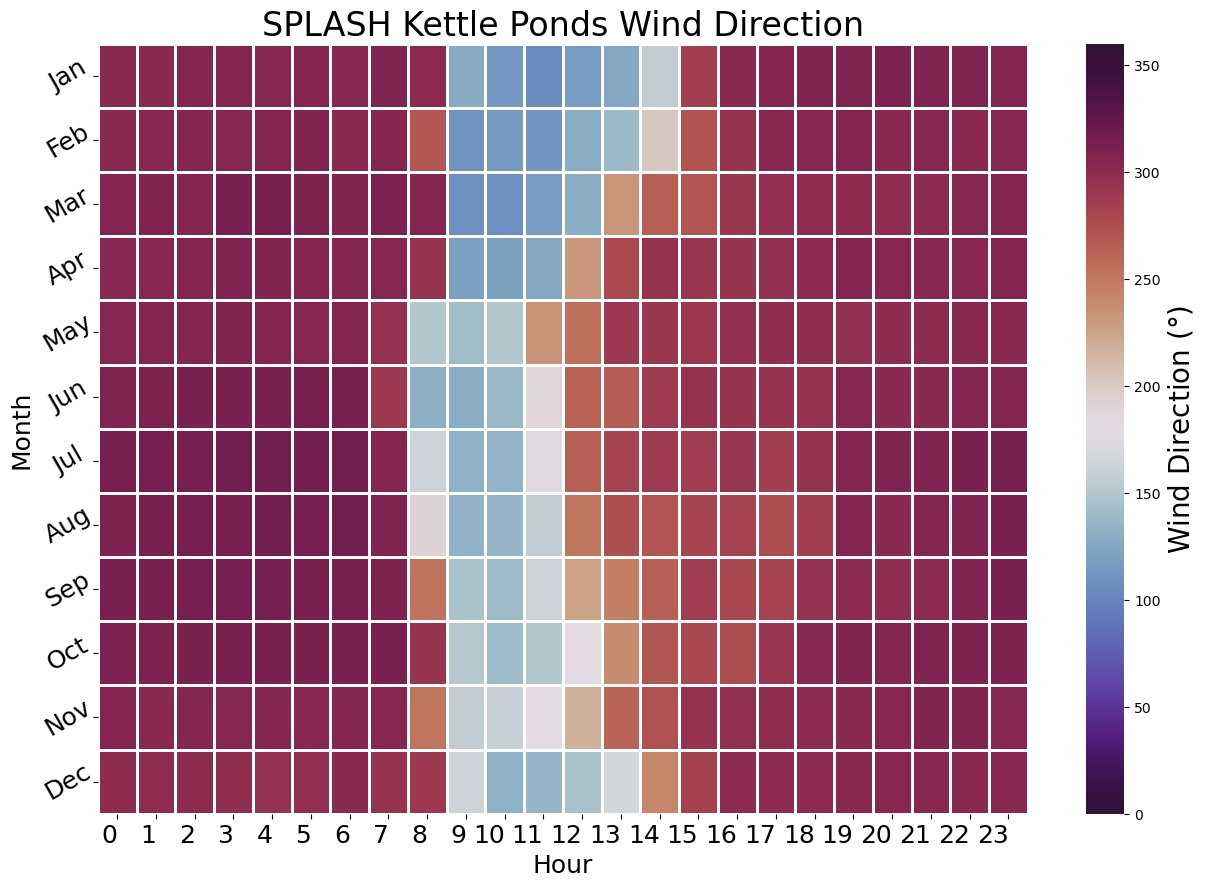

In [12]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(kettle_ponds_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(kettle_ponds_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SPLASH Kettle Ponds Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

### RADSYS data from Brush Creek

In [13]:
# downloaded from https://zenodo.org/records/10009600
all_files = glob.glob('../data/cbc/*.dat')
datasets = []
for fn in all_files:
    try:
        ckp_df = pd.read_csv(fn, 
                            skiprows=2, 
                            header=None, 
                            delim_whitespace=True, 
                            parse_dates={'time':[0,2,3,4,5]}, 
                            date_format='%Y %m %d %H %M',)
        datasets.append(met_data_formatting(ckp_df))
    except:
        print(fn)
        continue
    # read in data
radsys_ds = xr.concat(datasets, dim='time')
radsys_ds.attrs.update({'QC_flag':'0 for good data, 1 for bad data, 2 for questionable data',
                    'no_data': -9999.9,
                    'time':'UTC',
                    'reported_data':'Reported data are 1 minute averages of 1 second samples, reported times are the end of the 1-min. averaging period',
                    'datastreamname':'Radsys'})
# add a coordinate with LocalTime for Plotting
time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
radsys_ds.coords.update({'local_time':tz_corrected})


    # with open('./radsys_attributes.txt', 'r') as j:
    #     attribute_dict = json.loads(j.read())
attributes = attributes_dict
for variable in radsys_ds.variables:
    if variable in attributes.keys():
        radsys_ds[variable].attrs.update(attributes[variable])

../data/cbc/cbc22199.dat
../data/cbc/cbc22262.dat
../data/cbc/cbc22311.dat
../data/cbc/cbc22363.dat
../data/cbc/cbc23110.dat
../data/cbc/cbc23124.dat
../data/cbc/cbc23127.dat
../data/cbc/cbc23152.dat
../data/cbc/cbc23153.dat
../data/cbc/cbc23170.dat
../data/cbc/cbc23171.dat
../data/cbc/cbc23187.dat
../data/cbc/cbc23194.dat


In [14]:
cbc_radsys_df = radsys_ds.to_dataframe().set_index('local_time')
# fill -9999.9 with NaN
cbc_radsys_df = cbc_radsys_df.replace(-9999.9, np.nan)

In [15]:
cbc_radsys_df['u'] = -cbc_radsys_df['WindSpd'] * np.sin(np.deg2rad(cbc_radsys_df['WindDir']))
cbc_radsys_df['v'] = -cbc_radsys_df['WindSpd'] * np.cos(np.deg2rad(cbc_radsys_df['WindDir']))

In [16]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in cbc_radsys_df.index.month.unique():
    # component mean wind direction
    component_mean_dir = cbc_radsys_df[cbc_radsys_df.index.month == month]
    u = component_mean_dir.u.groupby(component_mean_dir.index.hour).mean()
    v = component_mean_dir.v.groupby(component_mean_dir.index.hour).mean()
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month

    # Median wind direction
    hourly_median_dir = cbc_radsys_df[cbc_radsys_df.index.month == month]['WindDir']
    hourly_median_dir = hourly_median_dir.groupby(hourly_median_dir.index.hour).median()
    hourly_median_dir.name=month
    tmp.append(hourly_median_dir)
brush_creek_hourly = pd.concat(tmp, axis=1).T
brush_creek_hourly = brush_creek_hourly.sort_index()

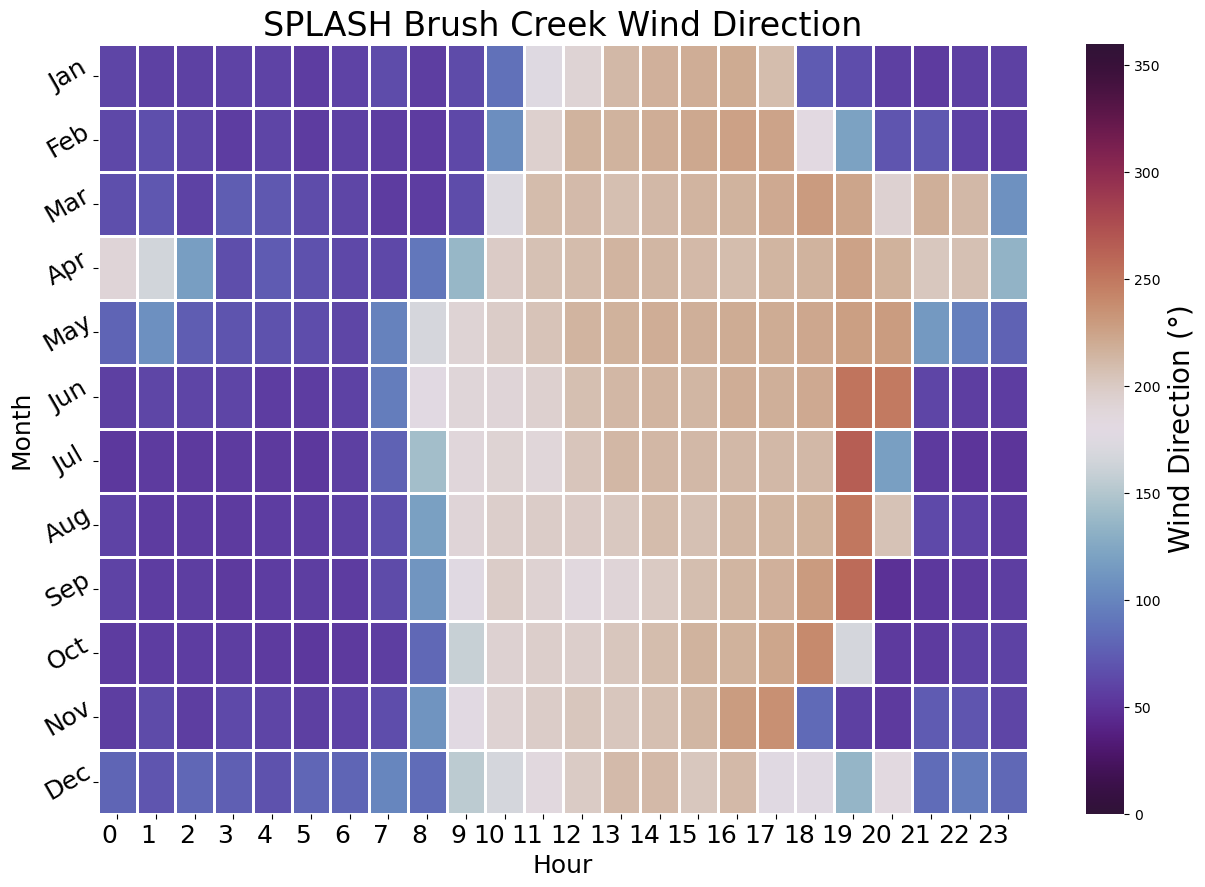

In [17]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(brush_creek_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(brush_creek_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SPLASH Brush Creek Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)

In [27]:
# helper tools
import scripts.helper_funcs as hf
import json
from act import discovery

### Setup to download SAIL data - should take several minutes

In [28]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

sail_datastream_dict = {
    # "radiosonde":"gucsondewnpnM1.b1",
    "met":"gucmetM1.b1",
    # "eddy_covariance_kettle_ponds":"guc30qcecorS3.s1",
    "eddy_covariance_kettle_ponds_noqc":"guc30ecorS3.b1",
    # "wind_profiler":"guc915rwpwindconM1.a1",
    # "doppler_lidar":"gucdlprofwind4newsM1.c1",
    # "laser_disdrometer_gothic":"gucldM1.b1",
    # "sebs":"gucsebsS3.b1"
    # "laser_disdrometer_mt_cb":"gucldS2.b1",
}

In [29]:
winter_22 = ('20211001','20220930')
winter_23 = ('20221001','20230930')

In [30]:
# Set the location of the data folder where this data will be stored
winter_22_folder = 'winter_21_22'
winter_23_folder = 'winter_22_23'
 # change to location of data folder on your machine
storage_directory = f'/storage/dlhogan/synoptic_sublimation/'
# create a sail_data folder if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data')):
    os.makedirs(os.path.join(storage_directory,'sail_data'))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_22_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_22_folder))
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_22_folder,'radiosonde')):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_22_folder,'radiosonde'))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_23_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_23_folder))
    # make a radiosonde folder if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_23_folder,'radiosonde')):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_23_folder,'radiosonde'))

### Download winter 2022 data from SAIL if needed
For now we will just get met and ecor

In [31]:
# load in the winter 22 data
sail_winter_22_folder = os.path.join(storage_directory,'sail_data',winter_22_folder)
# create empty data dictionary
w22_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():
    if (k =='radiosonde') & (len(os.listdir(os.path.join(sail_winter_22_folder,"radiosonde"))) > 0):
        print("Radiosonde data donwloaded. Data files include:")
        # list file names in the radiosonde folder
        for file in os.listdir(os.path.join(sail_winter_22_folder,"radiosonde")):
            print(file)
        print('-------------------')
    # Check if the file already exists
    elif (os.path.exists(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')): 
        print(f'{k}_{winter_22[0]}_{winter_22[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        if k == 'radiosonde':
            discovery.download_data(
                api_username,
                api_token,
                v,
                startdate=winter_22[0],
                enddate=winter_22[1],
                output=sail_winter_22_folder+'radiosonde/'
            )
        else:
            ds = hf.get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_22[0],
                        enddate=winter_22[1])
            ds.to_netcdf(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')
            w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')

met_20211001_20220930.nc already exists
-------------------
eddy_covariance_kettle_ponds_noqc_20211001_20220930.nc already exists
-------------------


### Download winter 2023 data from SAIL
For now we will just get met, ecor, and laser disdrometer data

In [32]:
# load in the winter 23 data
sail_winter_23_folder = os.path.join(storage_directory,'sail_data',winter_23_folder)
# create empty data dictionary
w23_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():
    if (k =='radiosonde') & (len(os.listdir(os.path.join(sail_winter_23_folder,"radiosonde"))) > 0):
        print("Radiosonde data donwloaded. Data files include:")
        # list file names in the radiosonde folder
        for file in os.listdir(os.path.join(sail_winter_23_folder,"radiosonde")):
            print(file)
        print('-------------------')
    # Check if the file already exists
    elif (os.path.exists(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')): 
        print(f'{k}_{winter_23[0]}_{winter_23[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        if k == 'radiosonde':
            discovery.download_data(
                api_username,
                api_token,
                v,
                startdate=winter_23[0],
                enddate=winter_23[1],
                output=sail_winter_23_folder+'radiosonde/'
            )
        else:
            ds = get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_23[0],
                        enddate=winter_23[1])
            ds.to_netcdf(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')
            w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')

met_20221001_20230930.nc already exists
-------------------
eddy_covariance_kettle_ponds_noqc_20221001_20230930.nc already exists
-------------------


In [33]:
# If this was already downloaded, we just need to access the files
ecor_22_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/eddy_covariance_kettle_ponds_noqc_20211001_20220930.nc')
ecor_23_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/eddy_covariance_kettle_ponds_noqc_20221001_20230930.nc')
met_22_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/met_20211001_20220930.nc')
met_23_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/met_20221001_20230930.nc')

# combine all data
met_ds = xr.concat([met_22_ds,met_23_ds],dim='time')
ecor_ds = xr.concat([ecor_22_ds,ecor_23_ds],dim='time')

In [34]:
# dumb way to add local time info
def add_local_time(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({'local_time':tz_corrected})
    return ds

### Gothic Met station

In [36]:
# Quick check on how much ecor data we are missing by month
((met_ds['wdir_vec_mean'].isnull().groupby(met_ds.time.dt.month).sum()/met_ds['wdir_vec_mean'].isnull().groupby(met_ds.time.dt.month).count())*100).values


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
met_ds['u'] = -met_ds['wspd_vec_mean'] * np.sin(np.deg2rad(met_ds['wdir_vec_mean']))
met_ds['v'] = -met_ds['wspd_vec_mean'] * np.cos(np.deg2rad(met_ds['wdir_vec_mean']))

In [38]:
# add local time and create dataframe
met_df = add_local_time(met_ds[['wdir_vec_mean', 'u','v']]).to_dataframe()
# sebs_df = add_local_time(sebs_ds['down_short_hemisp'].where(sebs_ds['qc_down_short_hemisp']==0)).to_dataframe()
met_df = met_df.set_index('local_time')
# sebs_df = sebs_df.set_index('local_time')

In [41]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in met_df.index.month.unique():
    # component mean wind direction
    component_mean_dir = met_df[met_df.index.month == month]
    u = component_mean_dir.u.groupby(component_mean_dir.index.hour).mean()
    v = component_mean_dir.v.groupby(component_mean_dir.index.hour).mean()
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month

    # Median wind direction
    hourly_median_dir = met_df[met_df.index.month == month]['wdir_vec_mean']
    hourly_median_dir = hourly_median_dir.groupby(hourly_median_dir.index.hour).median()
    hourly_median_dir.name=month
    tmp.append(hourly_median_dir)
met_df_hourly = pd.concat(tmp, axis=1).T

In [42]:
# Sort for plotting
met_ds_hourly = met_df_hourly.sort_index()


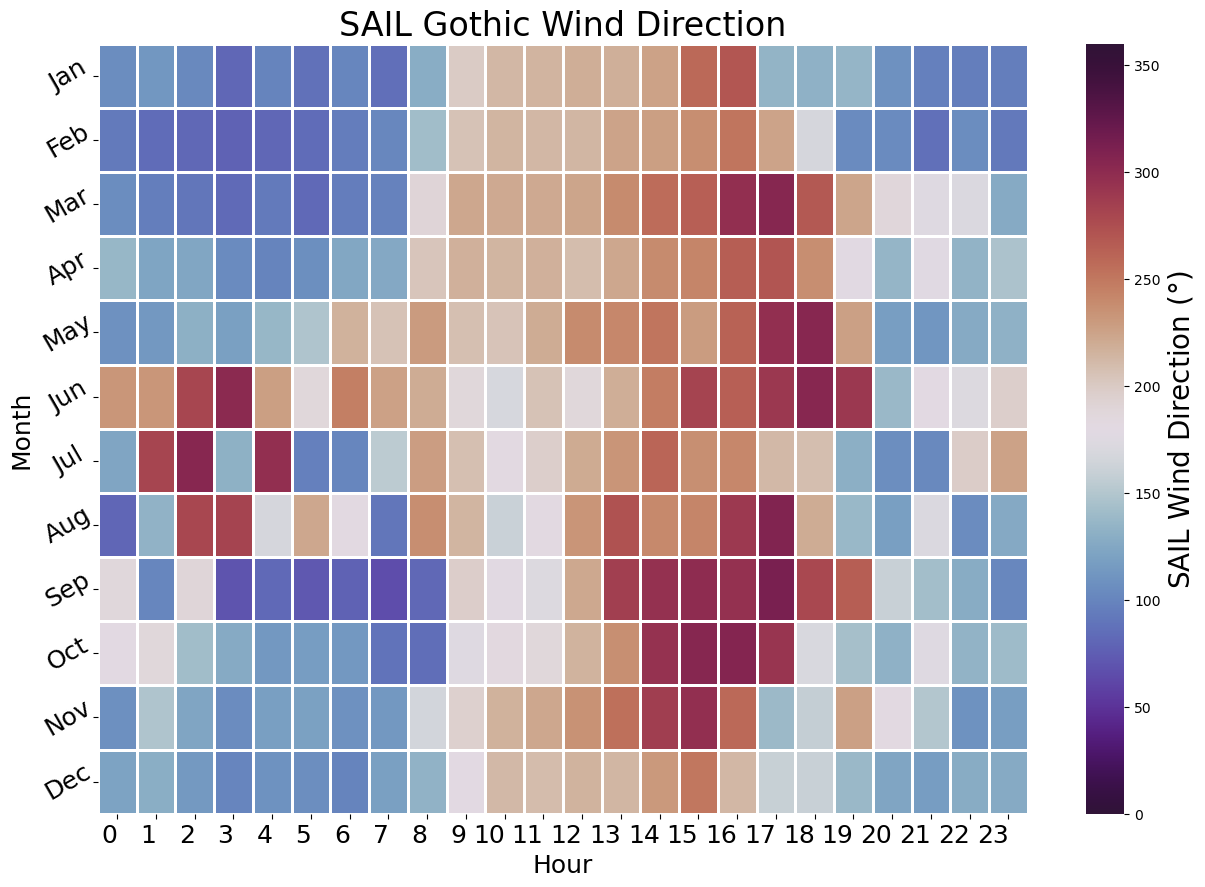

In [43]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(met_ds_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'SAIL Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(met_ds_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SAIL Gothic Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)


### Kettle Ponds ECOR

In [44]:
ecor_ds['u'] = -ecor_ds['wind_spd'] * np.sin(np.deg2rad(ecor_ds['wind_dir']))
ecor_ds['v'] = -ecor_ds['wind_spd'] * np.cos(np.deg2rad(ecor_ds['wind_dir']))

In [45]:
# add local time and create dataframe
ecor_df = add_local_time(ecor_ds[['wind_dir', 'u','v']]).to_dataframe()
# sebs_df = add_local_time(sebs_ds['down_short_hemisp'].where(sebs_ds['qc_down_short_hemisp']==0)).to_dataframe()
ecor_df = ecor_df.set_index('local_time')
# sebs_df = sebs_df.set_index('local_time')

In [46]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in ecor_df.index.month.unique():
    # component mean wind direction
    component_mean_dir = ecor_df[ecor_df.index.month == month]
    u = component_mean_dir.u.groupby(component_mean_dir.index.hour).mean()
    v = component_mean_dir.v.groupby(component_mean_dir.index.hour).mean()
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month

    # Median wind direction
    hourly_median_dir = ecor_df[ecor_df.index.month == month]['wind_dir']
    hourly_median_dir = hourly_median_dir.groupby(hourly_median_dir.index.hour).median()
    hourly_median_dir.name=month
    tmp.append(hourly_median_dir)
ecor_df_hourly = pd.concat(tmp, axis=1).T

# tmp=[]
# for month in sebs_df.index.month.unique():
#     a = sebs_df[sebs_df.index.month == month]['down_short_hemisp']
#     a = a.groupby(a.index.hour).mean()
#     a.name=month
#     tmp.append(a)
# sebs_ds_hourly = pd.concat(tmp, axis=1).T

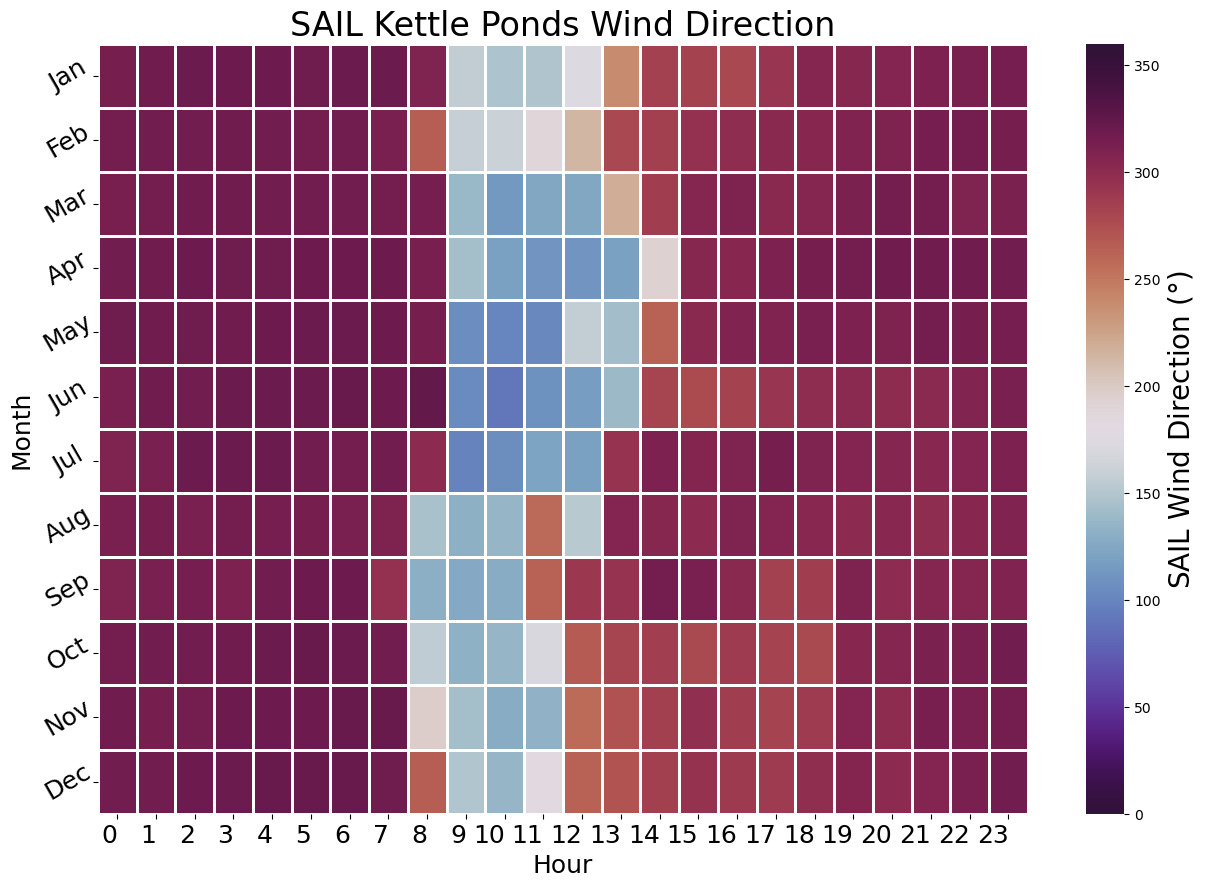

In [47]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(ecor_df_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'SAIL Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(ecor_df_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SAIL Kettle Ponds Wind Direction', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)


### SOS Data

In [48]:
from sublimpy import utils, variables, tidy

In [49]:
WIND_VARIABLES = [
# Sonic Anemometer Data for 4 towers
'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',
'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',
'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',
'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',
'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',
'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',
'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',
'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',
'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',
'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',
'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',
'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',
'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',
'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',
'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',
]

In [ ]:
%%capture
# Let's begin by downloading the SOS data and storing it in the /storage/ directory
# pip install sublimpy if not yet installed
# need to download qc files using ftp server
output_dir = '/storage/dlhogan/synoptic_sublimation/sos_data/sosqc/'
start_date = '20221101'
end_date = '20230619'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
sos_5min_ds = utils.download_sos_data(
                        start_date=start_date,
                        end_date=end_date,
                        variable_names=WIND_VARIABLES,
                        local_download_dir=output_dir,
                        cache=True
                    );  


In [ ]:
# skipping one day since it went into October when localizing time
sos_5min_ds = sos_5min_ds.sel(time=slice('2022-11-02', end_date))
sos_wind = add_local_time(sos_5min_ds[['spd_10m_c','dir_10m_c','u_10m_c','v_10m_c']]).to_dataframe()
sos_wind = sos_wind.set_index('local_time')
sos_wind['u'] = -sos_wind['spd_10m_c'] * np.sin(np.deg2rad(sos_wind['dir_10m_c']))
sos_wind['v'] = -sos_wind['spd_10m_c'] * np.cos(np.deg2rad(sos_wind['dir_10m_c']))


In [ ]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in sos_wind.index.month.unique():
    # component mean wind direction
    component_mean_dir = sos_wind[sos_wind.index.month == month]
    u = component_mean_dir.u.groupby(component_mean_dir.index.hour).mean()
    v = component_mean_dir.v.groupby(component_mean_dir.index.hour).mean()
    dir = pd.Series(270-np.rad2deg(np.arctan2(v,u)))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    dir.name=month

    # Median wind direction
    hourly_median_dir = sos_wind[sos_wind.index.month == month]['dir_10m_c']
    hourly_median_dir = hourly_median_dir.groupby(hourly_median_dir.index.hour).median()
    hourly_median_dir.name=month
    tmp.append(hourly_median_dir)
sos_df_hourly = pd.concat(tmp, axis=1).T
# add columns filled with nan for missing months
for month in idx:
    if month not in sos_df_hourly.index:
        sos_df_hourly.loc[month,:] = np.nan
sos_df_hourly = sos_df_hourly.sort_index()


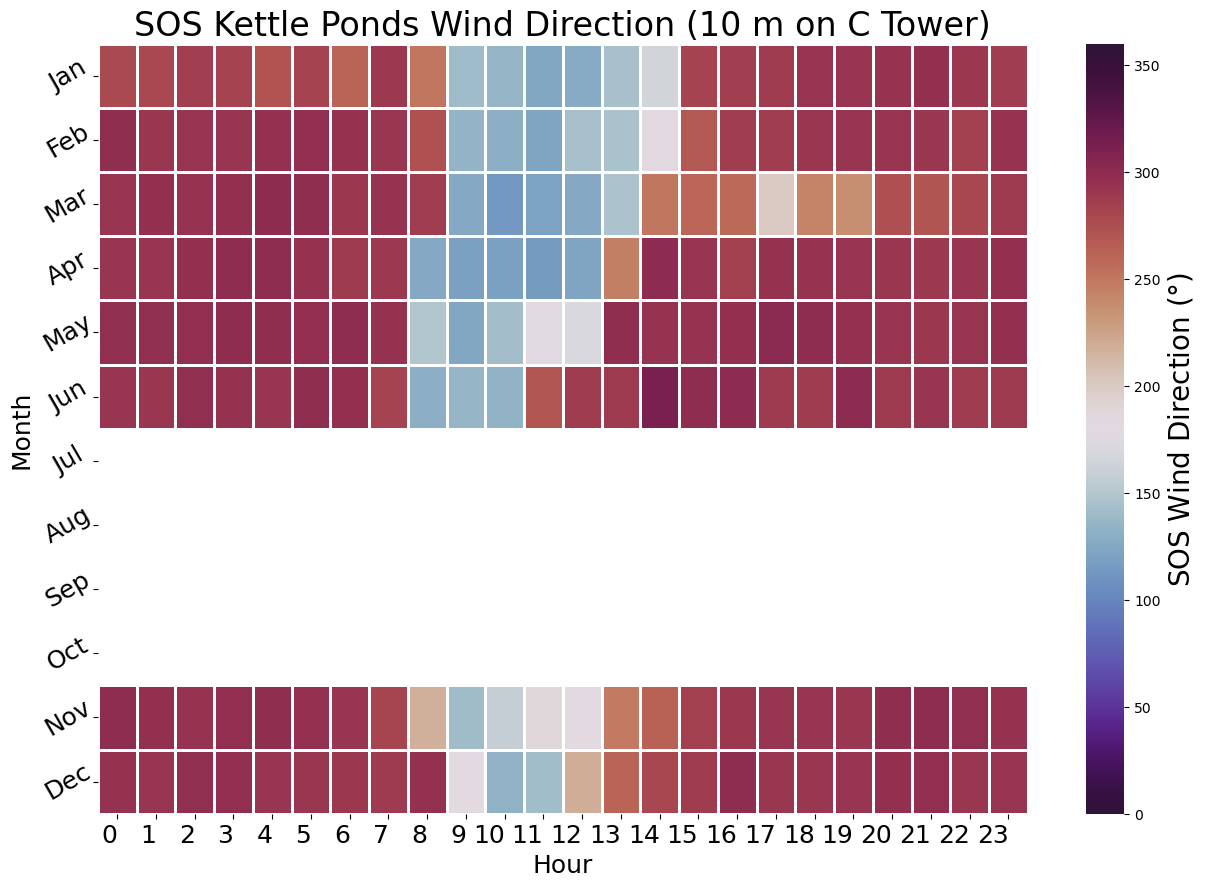

In [ ]:

fig, ax=plt.subplots(figsize=(15,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',]
sns.heatmap(sos_df_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'SOS Wind Direction ($\degree$)'}, ax=ax)
ax.set_xticklabels(sos_df_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SOS Kettle Ponds Wind Direction (10 m on C Tower)', size=24)
ax.figure.axes[-1].yaxis.label.set_size(20)


Save all

In [ ]:
roaring_judy_hourly.to_csv('../data/splash_roaring_judy_hourly_median.csv')
kettle_ponds_hourly.to_csv('../data/splash_kettle_ponds_hourly_median.csv')
brush_creek_hourly.to_csv('../data/splash_brush_creek_hourly_median.csv')
met_ds_hourly.to_csv('../data/sail_gothic_hourly_median.csv')
ecor_df_hourly.to_csv('../data/sail_kettle_ponds_hourly_median.csv')
sos_df_hourly.to_csv('../data/sos_hourly_median.csv')